In [1]:
from dataclasses import dataclass

import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from src.components.dvi.cmcd import CMCD
from src.components.dvi.dis import DIS
from src.components.dvinp import DVINP
from src.components.nn.control import Control
from src.components.nn.encoder import SingletonEncoder
from src.components.nn.schedule import (ConstantAnnealingSchedule,
                                        ConstantStepSizeSchedule,
                                        ContextualAnnealingSchedule,
                                        ContextualNoiseSchedule,
                                        ContextualStepSizeSchedule,
                                        CosineNoiseSchedule,
                                        CosineStepSizeSchedule)
from src.train.train_static import BetterStaticTargetTrainer
from src.utils.datasets import ContextTestDataset
from src.utils.distros import ContextualGMM
from src.utils.grid import (compute_bd, compute_jsd, create_grid,
                            eval_dist_on_grid, eval_hist_on_grid,
                            eval_kde_on_grid)
from src.utils.visualize import visualize_vals_on_grid_1d

In [2]:
device = torch.device("cpu") 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 1
    z_dim = 1
    h_dim = 32
    num_layers = 3
    non_linearity = "SiLU"
    learning_rate = 3e-3
    size = 128
    batch_size = 128

config = Config()

In [4]:
dataset = ContextTestDataset(size=config.size, c_dim=config.c_dim, sampling_factor=0)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
contextual_target = lambda context, _: ContextualGMM(context, offsets=(5, -5), scales=(1, 1), weights=(0.3, 0.7))

encoder = SingletonEncoder(
    c_dim=config.c_dim, 
    h_dim=config.h_dim
)

control = Control(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps,
    num_layers=3, # config.num_layers, 
    non_linearity=config.non_linearity, 
    is_cross_attentive=False,
    num_heads=None
)

cosine_noise_schedule = CosineNoiseSchedule(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    device=device,
    requires_grad=False
)

contextual_noise_schedule = ContextualNoiseSchedule(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps
)

constant_step_size_schedule = ConstantStepSizeSchedule(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    device=device
)

cosine_step_size_schedule = CosineStepSizeSchedule(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    device=device
)

contextual_step_size_schedule = ContextualStepSizeSchedule(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps
)

constant_annealing_schedule = ConstantAnnealingSchedule(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    device=device
)

contextual_annealing_schedule = ContextualAnnealingSchedule(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps
)

cdvi = DIS(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control=control, 
    step_size_schedule=constant_step_size_schedule,
    noise_schedule=cosine_noise_schedule,
    device=device, 
)

# cdvi = CMCD(
#     z_dim=config.z_dim, 
#     num_steps=config.num_steps, 
#     control=control,
#     step_size_schedule=cosine_step_size_schedule,
#     noise_schedule=cosine_noise_schedule,
#     annealing_schedule=constant_annealing_schedule,
#     device=device, 
# )

dvinp = DVINP(
    encoder=encoder,
    cdvi=cdvi,
    decoder=None,
    contextual_target=contextual_target
).to(device)

In [6]:
optimizer = torch.optim.Adam(params=dvinp.parameters(), lr=config.learning_rate)

trainer = BetterStaticTargetTrainer(
    device=device,
    dvinp=dvinp,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    wandb_logging=False,
    num_subtasks=1,
    sample_size=1
)

In [12]:
num_epochs = 500

losses = trainer.train(
    num_epochs=num_epochs, 
    max_clip_norm=None,
    alpha=None
)

100%|██████████| 1/1 [00:00<00:00, 43.00it/s, epoch=499, loss=59.5]


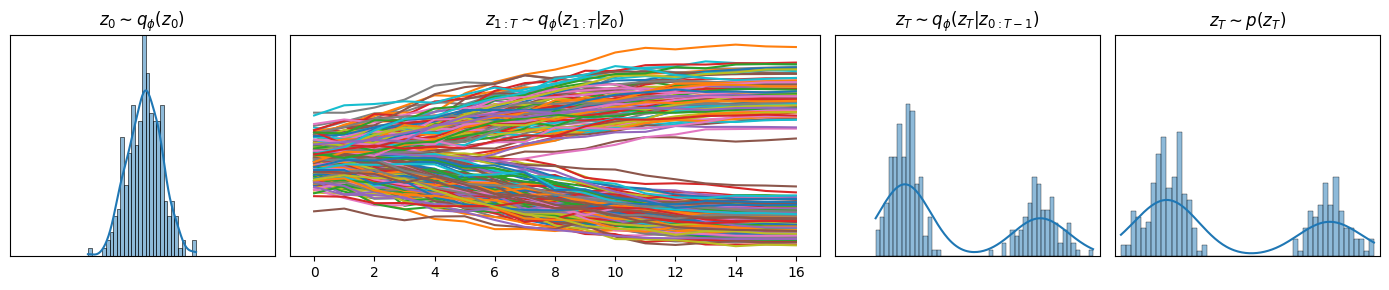

In [17]:
num_samples = 256

context = dataset.sampling_factor * torch.ones((1, num_samples, 1, config.c_dim), device=device)
target = dvinp.contextual_target(context, None)

r_aggr, r_non_aggr = dvinp.encoder(context.to(device), None)
_, _, z_samples = dvinp.cdvi.run_chain(target, r_aggr, r_non_aggr, None)

z_0_samples = z_samples[0].detach().cpu().numpy()
z_T_samples = z_samples[-1].detach().cpu().numpy()
z_trajectories = [[z[0, i, 0].detach().cpu().numpy() for z in z_samples] for i in range(num_samples)]
z_target_samples = target.sample().detach().cpu().numpy()

z_0_samples = z_0_samples.reshape(-1)
z_T_samples = z_T_samples.reshape(-1)
z_target_samples = z_target_samples.reshape(-1)

fig, ax = plt.subplots(1, 4, figsize=(14, 3), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

sns.histplot(z_0_samples, ax=ax[0], stat="density", bins=30, kde=True)
ax[0].set_title("$z_0\sim q_\phi(z_0)$")
ax[0].set_ylabel(None)
ax[0].set_xlim(-8, 8)
ax[0].set_ylim(0, 0.5)

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("$z_{1:T}\sim q_\phi(z_{1:T}|z_0)$")

sns.histplot(z_T_samples, ax=ax[2], stat="density", bins=50, kde=True)
ax[2].set_title("$z_T\sim q_\phi(z_T|z_{0:T-1})$")
ax[2].set_ylabel(None)
ax[2].set_xlim(-8, 8)
ax[2].set_ylim(0, 0.5)

sns.histplot(z_target_samples, ax=ax[3], stat="density", bins=50, kde=True)
ax[3].set_title("$z_T\sim p(z_T)$")
ax[3].set_ylabel(None)
ax[3].set_xlim(-8, 8)
ax[3].set_ylim(0, 0.5)

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

ax[0].set_xticks([])

ax[2].set_xticks([])
ax[3].set_xticks([])

plt.tight_layout()
plt.show()

In [8]:
ranges = [(-8, 8)]
num = int(num_samples ** 0.5)

grid = create_grid(ranges, num)

target_vals = eval_dist_on_grid(grid, target, 1, num_samples,device)
dvi_vals = eval_kde_on_grid(grid, z_T_samples)
dvi_vals_2 = eval_hist_on_grid(z_T_samples, ranges, num)

jsd = compute_jsd(target_vals, dvi_vals)
bd = compute_bd(target_vals, dvi_vals)

print(f"jsd: {jsd}, bd: {bd}")

visualize_vals_on_grid_1d(grid, target_vals)
visualize_vals_on_grid_1d(grid, dvi_vals)
visualize_vals_on_grid_1d(grid, dvi_vals_2)

RuntimeError: shape '[1, 256, -1]' is invalid for input of size 16